In [8]:
from LorenzEDMD.EDMD.EDMD import EDMD_CHEB
from typing import List, Tuple
from matplotlib import pyplot as plt
import numpy as np
import pickle
from LorenzEDMD.utils.data_processing import (
    normalise_data_chebyshev, 
    get_acf,
    Koopman_correlation_function,
    )
from LorenzEDMD.dynamical_system.Lorenz import lorenz63
from LorenzEDMD.EDMD.EDMD import TSVD
import matplotlib
import plotly.graph_objects as go
from tqdm import tqdm
from LorenzEDMD.utils.paths import get_data_folder_path

matplotlib.rcParams.update({
    "text.usetex": True,  # Use LaTeX to render text
    "font.family": "serif",  # Use serif font (default in LaTeX)
    "text.latex.preamble": r"\usepackage{amsmath}"  # Optional: better math support
})

### Load EDMD data

In [9]:
data_path = get_data_folder_path()
f_name = "edmd_smalldt.pkl"#"edmd_prova.pkl"

with open(data_path / f_name,"rb") as f:
    results = pickle.load(f)

EDMDS : List[List[EDMD_CHEB]] = results["edmd results"]
lorenz : lorenz63 = results["lorenz settings"] 

degrees = [x[0].degree for x in EDMDS]
flight_times = [x.flight_time for x in EDMDS[0]]

In [17]:
len( EDMDS[0][0].indices )

560

In [19]:
dictionary = {}
for x in EDMDS:
    dictionary[x[0].degree] = len(x[0].indices)
dictionary

{13: 560, 14: 680, 15: 816, 16: 969, 17: 1140, 18: 1330, 19: 1540, 20: 1771}

### Get the data for the response

In [7]:
### From time series
lorenz_cf_traj = lorenz63()
lorenz_cf_traj.noise = lorenz.noise
lorenz_cf_traj.tau = 10
lorenz_cf_traj.t_span = (0,50000)
t, X = lorenz_cf_traj.integrate_EM()
scaled, data_min,data_max = normalise_data_chebyshev(X)


xmax , ymax, zmax = data_max
xmin, ymin, zmin = data_min
scale = (zmax - zmin) / 2 

scale = {
    "x" : (xmax - xmin) / 2 , 
    "y" : (ymax - ymin) / 2,
    "z" : (zmax- zmin) / 2,
    "x^2" : ( (xmax - xmin) / 2 )**2,
    "y^2" : ((ymax - ymin) / 2)**2,
    "z^2" : ((zmax- zmin) / 2) **2,
    "xy" : (xmax - xmin) / 2 * (ymax - ymin) / 2
}

100%|██████████| 50000000/50000000 [07:26<00:00, 111869.48it/s]


#### Now loop over different degrees

In [11]:
eig_to_keep = 50 ; tau_threshold = -1.5 
spectrum = [] ; GreenFunctions = []

for degree_number,degree in enumerate(degrees):
    edmd_flight_times = EDMDS[degree_number]
    edmd : EDMD_CHEB = edmd_flight_times[0] 

    # Regularisation with TSVDS
    tsvd_regulariser = TSVD(rel_threshold=1e-5)
    Kreduced = tsvd_regulariser.decompose(edmd)

    # Get spectral properties
    tsvd_regulariser.get_spectral_properties()
    lambdas = np.log(tsvd_regulariser.eigenvalues) / ( lorenz.dt * lorenz.tau * edmd.flight_time)

    # Get decomposition of observables
    decompositions = edmd.get_decomposition_observables()
    projections_dictionary = decompositions["z"]

    # Evaluate the moments on the trajectory
    batch_size = 100_000
    n_total = scaled.shape[0]
    range_batches = range(0, n_total, batch_size)
    n_batches = len(range_batches)

    # Optional: get output shape from one batch
    example = edmd.evaluate_dictionary_batch(scaled[:1, :])
    avgs = np.zeros(example.shape[1])

    for i in tqdm(range_batches):
        batch = scaled[i:min(i + batch_size, n_total), :]
        Psi_trajectory = edmd.evaluate_dictionary_batch(batch)
        x_traj = batch[:, 0]
        avgs += np.mean(x_traj[:, None] * Psi_trajectory, axis=0)

    avgs /= n_batches

    # Scalar product in SVD space
    Gr = np.diag(tsvd_regulariser.Sr)
    projections_reduced = tsvd_regulariser.Ur.T @ projections_dictionary


    # Thresholding on a subset of modes
    
    indx = np.where(np.real(lambdas) > tau_threshold)[0] 
    lambdas_good = lambdas[indx]

    # Projection onto the subspace spanned by the leading n selected modes
    Vn = tsvd_regulariser.reduced_right_eigvecs[:,indx]
    G_koop_n = Vn.T.conj() @ Gr @ Vn
    project_to_koopman_space = np.linalg.pinv(G_koop_n) @ Vn.conj().T @ Gr
    fn =  project_to_koopman_space @ projections_reduced

    # Working just in reduced space
    Ay = edmd.build_derivative_matrix(direction=1)
    reduced_der_operator = tsvd_regulariser.Ur.T @ Ay.T @ tsvd_regulariser.Ur
    reduced_delta = tsvd_regulariser.Ur.T @ avgs
    reduced_Gamma_2 = np.diag( 1 / (tsvd_regulariser.Sr + 0.001 )) @ reduced_der_operator @ reduced_delta
    koopman_Gamma_2 = project_to_koopman_space @ reduced_Gamma_2

    Gkoop = lambda t: Koopman_correlation_function(t,G_koop_n,fn,koopman_Gamma_2,lambdas_good )

    nlags = 1500
    Dt = lorenz_cf_traj.dt * lorenz_cf_traj.tau * edmd.flight_time
    lags = np.linspace(0, nlags * Dt, nlags + 1)
    Gkoop = np.array( [np.real( Gkoop(lag) ) for lag in lags] )

    GreenKoopPhysicalSpace = Gkoop*scale["z"]

    spectrum.append(lambdas[:eig_to_keep])
    GreenFunctions.append(GreenKoopPhysicalSpace)

100%|██████████| 50/50 [02:28<00:00,  2.98s/it]


In [57]:
len( degrees )

8

In [50]:
new_G = [x[1:] for x in GreenFunctions]

dictionary = {
    'spectrum' : np.stack(spectrum,axis=0),
    'degrees' : degrees,
    'GreenFunctions' : np.stack(new_G,axis=0),
    't' : lags[1:]
}

In [2]:
data_path = get_data_folder_path()
f_name = "reconstruction_multiple.pkl"

with open(data_path / f_name, "wb") as f:
    pickle.dump(dictionary, f)

NameError: name 'dictionary' is not defined

In [55]:
from scipy.io import savemat
data_path = get_data_folder_path()
f_name = 'Response_Lorenz_Z_Multiple_Reconstruction.mat'

with open(data_path / f_name, "wb") as f:
    savemat(f,dictionary)

In [17]:
f_name = "response_cluster.pkl"
with open(data_path/f_name,"rb") as f:
    response = pickle.load(f)

RP = response["Positive Response"]
RM = response["Negative Response"]
amplitudes = response["Amplitudes"]

Gs = []
for rp, rm, eps in zip(RP,RM,amplitudes):
    G = (rp -rm) / (2*eps)
    Gs.append(G)
# response["Positive Response"]

observable_index = {
    "x" : 0,
    "y" : 1,
    "z" : 2,
    "x^2" : 3,
    "y^2" : 4,
    "z^2" : 5
}

tspan = response["Response Settings"].t_span 
t = np.arange(tspan[0],tspan[-1],response["Response Settings"].dt )
tresp = t[::response["Response Settings"].tau]

G = np.zeros(Gs[0].shape)
for g in Gs:
    G += g / len(Gs)

(-1.0, 15.0)

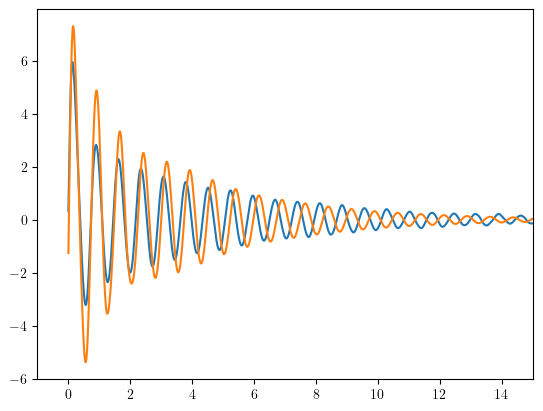

In [23]:
plt.plot(tresp,G[:,2])
plt.plot(lags,GreenFunctions[-1])
plt.xlim(-1,15)

In [6]:
import pickle

data_path = get_data_folder_path()
f_name = "reconstruction_multiple.pkl"

with open(data_path / f_name, "rb") as f:
    data = pickle.load(f)

EOFError: Ran out of input

In [7]:
degrees = [14,16,18,20]
for degree_number,degree in enumerate(degrees):
    edmd_flight_times = EDMDS[degree_number]
    edmd : EDMD_CHEB = edmd_flight_times[0] 
    print(edmd.degree)

NameError: name 'EDMDS' is not defined